# Segment 7.2 

Choose a publicly available dataset from Kaggle that appears interesting to you. Create a well-documented and easily reproducible Jupyter notebook that does analysis. Within the notebook, highlight some of the things that you found most interesting from the analysis.

## Summary of EDA

#### Overall Insights

- no "missing values" but many variables do have categories that can best be classifed as "unknown" 
- most variables are not highly correlated with each other, except for loudness and energy

- unbalanced dataset with 3631 unsuccessful songs and 629 hits
- year ranges from 1990 to 2010, with roughly the same number of songs in each year



#### Main Insight 1
During EDA, I found that the time signature, tempo, and key estimates are all associated with a confidence level. For example, songs with 100% key confidence are 100% certain in the listed key signature. I sampled songs with higher confidences to verify the key and tim signatures (more details in respective sections). 

However, many songs tend to vary speeds and change key, especially in the chorus, which is something this dataset does not consider. Therefore, to these confidence levels should be used to represent variability since the EDA has shown these variables to be more informative than the estimates themselves with lower confidence indicating more variability and higher confidence representing consistency. 

#### Main Insight 2
The loudness variable is highly correlated (0.74 Pearson's correlation) with energy as songs with high energy are also songs that are considered loud. Much more information such as danceabilty goes into energy than just volume so this is likely a more representative variable. 


#### Main Insight 3
Another interesting result of the EDA are the `Timbre` variables. Originally recorded as minimum and maximum values over the course of a song, I graphed the average timbre of hit songs verses non-hit songs (see graph below for reference). The green lines are hit songs while the red lines are non-hit songs. 

Regardless of a song's popularity, a similar trend appears. The timbre starts off very small, then has a huge variability until it levels off after about the mid point of a song. I would like to further investigate to see if this trend is constant throughout the years. It is well known that music evolves over time so comparing timbres might provide insight into the change in musical structure.

However, it is also important to note that hit songs are slightly more drastic than non-hit songs as they have higher max averages and lower min averages. This may prove to be significant in the modeling process especially used as an interaction effect with year.



In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
df = pd.read_csv("songs.csv",
                 encoding = "latin-1") # file stored as ISO-8859-1 (single-byte encoding)

# change options to view all columns and only a few rows
pd.options.display.max_columns = 40
pd.options.display.max_rows = 12

In [3]:
print(df.shape)
print(df.columns)

(7574, 39)
Index(['year', 'songtitle', 'artistname', 'songID', 'artistID',
       'timesignature', 'timesignature_confidence', 'loudness', 'tempo',
       'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max',
       'Top10'],
      dtype='object')


In [4]:
df.head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2010,This Is the House That Doubt Built,A Day to Remember,SOBGGAB12C5664F054,AROBSHL1187B9AFB01,3,0.853,-4.262,91.525,0.953,11,0.453,0.966656,0.024,0.002,57.342,-6.496,171.093,-81.664,95.117,-285.049,259.426,-40.385,73.630,-104.683,183.089,-88.771,73.549,-71.127,82.475,-52.025,39.116,-35.368,71.642,-126.440,18.658,-44.770,25.989,0
1,2010,Sticks & Bricks,A Day to Remember,SOPAQHU1315CD47F31,AROBSHL1187B9AFB01,4,1.000,-4.051,140.048,0.921,10,0.469,0.984710,0.025,0.000,57.414,-37.351,171.130,-149.589,180.334,-380.143,384.166,-48.662,100.414,-87.267,42.798,-86.895,75.455,-65.807,106.918,-61.320,35.378,-81.928,74.574,-103.808,121.935,-38.892,22.513,0
2,2010,All I Want,A Day to Remember,SOOIZOU1376E7C6386,AROBSHL1187B9AFB01,4,1.000,-3.571,160.512,0.489,2,0.209,0.989900,0.026,0.003,57.422,-17.222,171.060,-72.912,157.925,-203.984,251.258,-66.044,152.095,-98.673,141.365,-88.874,66.504,-67.433,80.621,-59.773,45.979,-46.293,59.904,-108.313,33.300,-43.733,25.744,0
3,2010,It's Complicated,A Day to Remember,SODRYWD1315CD49DBE,AROBSHL1187B9AFB01,4,1.000,-3.815,97.525,0.794,1,0.632,0.939207,0.013,0.000,57.765,-32.083,220.895,-138.596,173.365,-73.490,373.492,-55.607,119.158,-77.515,141.178,-70.790,64.540,-63.667,96.675,-78.660,41.088,-49.194,95.440,-102.676,46.422,-59.439,37.082,0
4,2010,2nd Sucks,A Day to Remember,SOICMQB1315CD46EE3,AROBSHL1187B9AFB01,4,0.788,-4.707,140.053,0.286,6,0.483,0.987738,0.063,0.000,56.872,-223.922,171.130,-147.153,166.008,-128.082,389.419,-43.908,99.332,-96.147,38.303,-110.757,72.391,-55.935,110.332,-56.450,37.555,-48.588,67.570,-52.796,22.888,-50.414,32.758,0


## Exploratory Data Analysis

In [5]:
df.describe()

,year,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
count,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000
mean,2001.455902,3.893979,0.853307,-8.817262,107.348267,0.622866,5.384605,0.433843,0.675471,0.010817,4.122762,54.461920,-110.785379,212.342265,-136.885915,136.672989,-186.107349,211.813801,-65.281655,108.227392,-103.997576,127.044908,-80.944168,72.166358,-84.312560,95.653221,-63.703984,50.057489,-59.515016,68.028067,-87.340055,55.520722,-50.868457,47.490774,0.147742
std,5.815223,0.532561,0.243748,4.377079,24.665030,0.304656,3.572579,0.273826,0.243473,0.013671,8.510484,3.991371,72.111815,59.923191,45.911893,49.951715,76.157411,103.769907,21.749448,33.280283,36.366486,58.555163,20.764510,20.068926,28.019622,26.859726,15.970244,14.463524,17.190527,20.381321,30.464274,23.549473,11.701530,12.463966,0.354868
min,1990.000000,0.000000,0.000000,-42.451000,0.000000,0.000000,0.000000,0.000000,0.000020,0.000000,0.000000,12.582000,-333.718000,-74.367000,-324.858000,-0.832000,-495.358000,12.847000,-207.067000,-0.651000,-262.476000,-22.411000,-152.170000,12.697000,-214.791000,15.699000,-158.756000,-25.955000,-149.507000,8.415000,-208.819000,-6.359000,-145.599000,7.200000,0.000000
25%,1997.000000,4.000000,0.819250,-10.847000,88.860250,0.372000,2.000000,0.204000,0.500138,0.003000,0.000000,53.119500,-160.116250,171.130000,-167.641750,100.519500,-226.871250,127.137000,-77.688750,83.965500,-113.579000,84.643750,-94.792000,59.041250,-101.170750,76.498000,-73.050750,40.584500,-70.282500,53.037250,-105.130250,39.196000,-58.058000,38.975250,0.000000
50%,2002.000000,4.000000,0.979000,-7.649000,103.268000,0.701500,6.000000,0.451500,0.718160,0.007000,0.027000,55.535000,-107.750000,194.400000,-136.602000,129.908000,-170.611500,189.504000,-63.828000,107.422000,-95.467500,119.903500,-80.417500,70.467500,-81.797500,94.632500,-62.661500,49.220000,-58.650000,65.935000,-83.074000,50.895000,-50.892500,46.437500,0.000000
75%,2006.000000,4.000000,1.000000,-5.640000,124.800500,0.892000,9.000000,0.646000,0.887396,0.014000,2.771500,57.077750,-59.708250,239.242250,-106.512500,166.121250,-131.559500,290.717250,-51.344000,130.285750,-81.015250,162.338500,-66.521000,83.189750,-64.301000,112.708250,-52.982750,58.462000,-47.699750,81.267000,-64.518000,66.593000,-43.292250,55.030250,0.000000
max,2010.000000,7.000000,1.000000,1.305000,244.307000,1.000000,11.000000,1.000000,0.998492,0.541000,48.353000,64.007000,123.730000,549.968000,34.566000,397.095000,-21.546000,499.623000,51.426000,257.801000,-42.173000,350.936000,4.503000,208.391000,5.153000,214.819000,-2.382000,144.985000,1.140000,161.518000,-10.640000,192.417000,-6.497000,110.272000,1.000000


The above summary indicates that none of the variables have "missing values" according to the count. However, since this dataset does not have a data dictionary, we will be exploring each variable to understand what they represent.

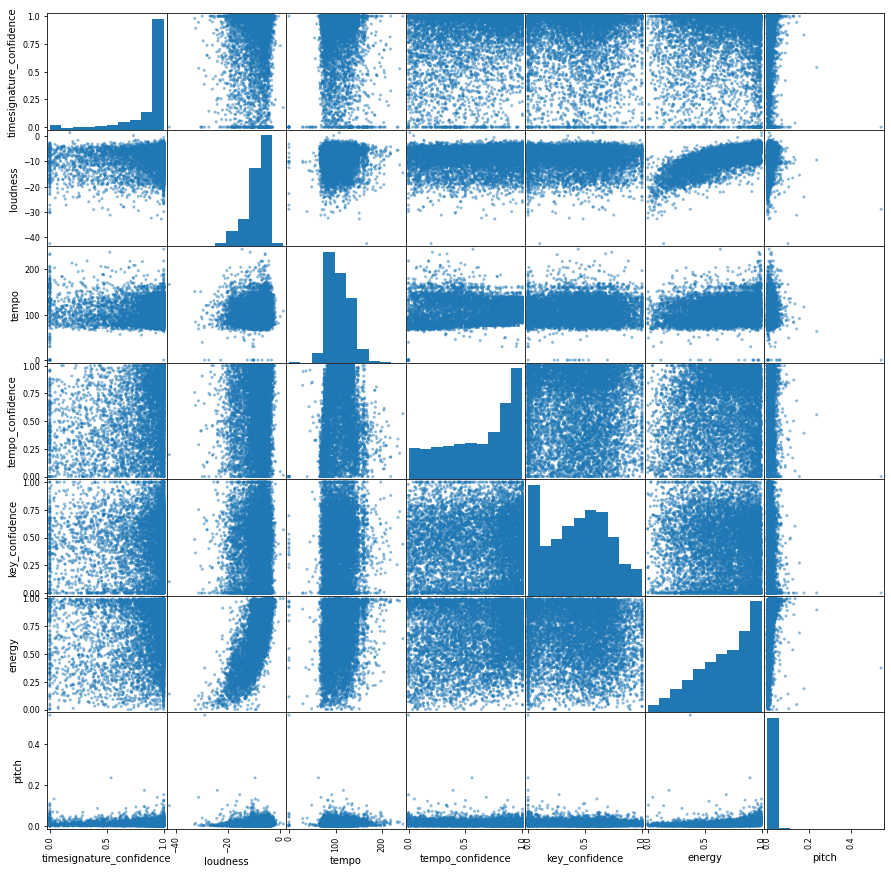

In [71]:

pd.plotting.scatter_matrix(df[[
    'timesignature_confidence','loudness','tempo','tempo_confidence',
    'key_confidence','energy','pitch'
]], figsize = (15, 15), diagonal = 'hist');



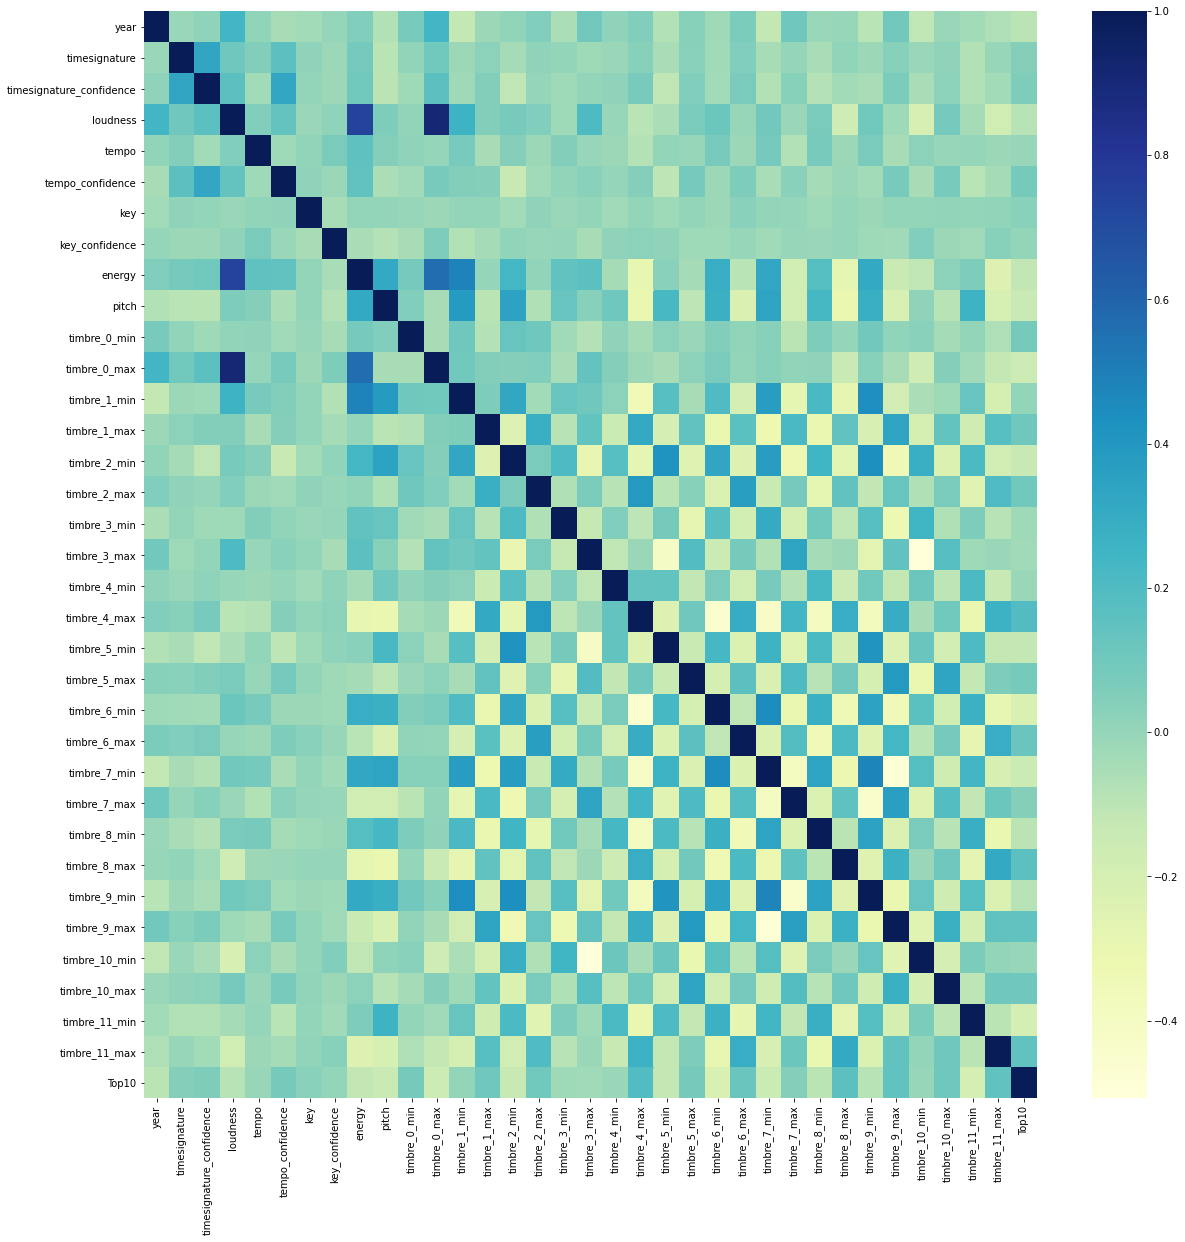

In [72]:
plt.figure(figsize = (20, 20))
sns.heatmap(df.corr(), cmap="YlGnBu")
plt.show()

### **Top 10** (Outcome Variable)
- a binary variable indicating whether or not a song made it to the Top 10 of the Billboard Hot 100 Chart 
- 1 if it did, and 0 otherwise

In [8]:
df['Top10'].value_counts(sort=False) # about 17% of data are "successes"

0    6455
1    1119
Name: Top10, dtype: int64

###  **Year**
 - the year of song release

In [9]:
print(min(df['year']), max(df['year']))

1990 2010


In [10]:
from collections import Counter
from collections import OrderedDict 
a = Counter(df['year'])
b = OrderedDict(sorted(a.items())) 
b

OrderedDict([(1990, 328),
             (1991, 196),
             (1992, 186),
             (1993, 324),
             (1994, 198),
             (1995, 258),
             (1996, 178),
             (1997, 329),
             (1998, 380),
             (1999, 357),
             (2000, 363),
             (2001, 282),
             (2002, 518),
             (2003, 434),
             (2004, 479),
             (2005, 392),
             (2006, 479),
             (2007, 622),
             (2008, 415),
             (2009, 483),
             (2010, 373)])

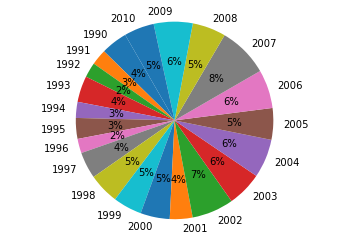

In [11]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(b.keys())
sizes = list(b.values())

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=120)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### **Songs and Artists**
- Title
- ID for identification

These will not be used in the model. I will only double check that each row corresponds to a unique song and artist combination.

In [12]:
# group by song and artist since some songs share titles

df.groupby(['songtitle', 'artistname']).ngroups # unique, as expected

7574

### **Time Signature**
- an estimate of the time signature 
- confidence in the estimate


In [13]:
df['timesignature'].value_counts(sort=True) # 6 different time signatures

4    6787
3     503
1     143
5     112
7      19
0      10
Name: timesignature, dtype: int64

The first step in exploring this variable is to find out what the values represent. In music, the most common time signature is 4/4, and is rightly referred to as common time. It is used in every music genre and is often the assumed time signature of any piece with an even beat (notice how it is the only even time signature in this dataset). Because of this reasoning, I believe that the 4 in this variable represents common time because it is the most popular.

To verify this reasoning I will sample the audio of songs that have a 100% confidence in their time signature estimate.

In [14]:
# only view time signature 4 with 100%
df.loc[(df['timesignature']==4) 
       & (df['timesignature_confidence'] ==1) ,].head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
1,2010,Sticks & Bricks,A Day to Remember,SOPAQHU1315CD47F31,AROBSHL1187B9AFB01,4,1.0,-4.051,140.048,0.921,10,0.469,0.984710,0.025,0.000,57.414,-37.351,171.130,-149.589,180.334,-380.143,384.166,-48.662,100.414,-87.267,42.798,-86.895,75.455,-65.807,106.918,-61.320,35.378,-81.928,74.574,-103.808,121.935,-38.892,22.513,0
2,2010,All I Want,A Day to Remember,SOOIZOU1376E7C6386,AROBSHL1187B9AFB01,4,1.0,-3.571,160.512,0.489,2,0.209,0.989900,0.026,0.003,57.422,-17.222,171.060,-72.912,157.925,-203.984,251.258,-66.044,152.095,-98.673,141.365,-88.874,66.504,-67.433,80.621,-59.773,45.979,-46.293,59.904,-108.313,33.300,-43.733,25.744,0
3,2010,It's Complicated,A Day to Remember,SODRYWD1315CD49DBE,AROBSHL1187B9AFB01,4,1.0,-3.815,97.525,0.794,1,0.632,0.939207,0.013,0.000,57.765,-32.083,220.895,-138.596,173.365,-73.490,373.492,-55.607,119.158,-77.515,141.178,-70.790,64.540,-63.667,96.675,-78.660,41.088,-49.194,95.440,-102.676,46.422,-59.439,37.082,0
5,2010,Better Off This Way,A Day to Remember,SOCEYON1315CD4A23E,AROBSHL1187B9AFB01,4,1.0,-3.807,160.366,0.347,4,0.627,0.979953,0.038,0.000,57.083,-40.408,174.002,-83.829,126.879,-100.119,173.607,-33.789,66.904,-84.451,47.268,-71.219,71.239,-79.948,91.117,-54.378,53.808,-33.183,54.657,-64.478,34.522,-40.922,36.453,0
16,2010,A Real Clever Trick Fur a Bear,Analog Rebellion,SOQILMH135A1BECDBF,ARYGZHO1271F5760D2,4,1.0,-9.570,99.997,0.795,7,0.740,0.550271,0.003,22.045,55.172,-227.259,155.296,-149.160,137.864,-123.286,173.038,-60.243,134.934,-94.189,54.580,-79.387,42.651,-102.108,59.696,-85.226,57.790,-59.308,56.051,-88.176,52.429,-51.279,39.258,0


A sample from the above list verified that 4 is common time. Using this same logic, we will further explore the other values by sampling the audio of songs that have at least a 80% time signature confidence to confirm. I chose 80% to give wiggle room for songs that might have different time signatures for the choruses compared to the verses, as this is done often in the music industry.

In [15]:
# only view time signature 3 with at least 80%
df.loc[(df['timesignature']==3) 
       & (df['timesignature_confidence'] > 0.8) ,].head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2010,This Is the House That Doubt Built,A Day to Remember,SOBGGAB12C5664F054,AROBSHL1187B9AFB01,3,0.853,-4.262,91.525,0.953,11,0.453,0.966656,0.024,0.002,57.342,-6.496,171.093,-81.664,95.117,-285.049,259.426,-40.385,73.630,-104.683,183.089,-88.771,73.549,-71.127,82.475,-52.025,39.116,-35.368,71.642,-126.440,18.658,-44.770,25.989,0
11,2010,Phillip Garrido,Analog Rebellion,SOCWDID12AB018B90C,ARYGZHO1271F5760D2,3,0.937,-7.738,135.939,0.349,1,0.000,0.771630,0.009,14.627,57.259,-177.436,138.208,-149.301,79.353,-178.687,160.407,-54.412,125.742,-98.641,173.556,-71.076,61.822,-70.264,156.782,-43.490,62.512,-57.880,55.263,-105.431,62.563,-50.593,40.919,0
12,2010,I Am a Ghost (Artifact),Analog Rebellion,SONHQSS12AB018B90F,ARYGZHO1271F5760D2,3,0.802,-12.009,104.933,0.703,2,0.284,0.311863,0.004,11.260,52.106,-262.437,97.823,-147.817,89.915,-246.274,163.506,-36.385,146.273,-86.777,181.417,-92.358,67.584,-111.014,80.456,-67.876,64.149,-80.063,156.534,-116.180,100.165,-46.886,49.908,0
28,2010,Canadian Ten,Butch Walker,SOGJJQP12AF72A47D0,AR7NQDM1187FB3BEAA,3,0.930,-8.419,70.179,0.215,4,0.769,0.444829,0.008,0.288,56.843,-191.797,409.296,-125.096,167.969,-207.082,345.841,-68.084,147.634,-73.979,93.028,-61.742,86.875,-113.055,123.026,-69.466,58.806,-106.496,107.306,-85.882,59.408,-40.890,59.936,0
66,2010,After the Earthquake,Eels,SOAFCZJ1315CD3F8A2,ARZGTK71187B9AC7F5,3,1.000,-19.194,125.025,0.742,7,0.578,0.116666,0.000,0.000,44.089,-284.513,171.123,-81.659,176.044,-115.929,144.494,-14.696,131.640,-96.932,91.941,-57.926,43.206,-46.115,196.309,-31.194,44.596,-59.623,27.303,-67.428,42.047,-42.906,24.210,0


A sample of the above songs indicate that a value of 3 is indeed associated with songs of a 3/4 or 6/8 time signature. Notice how they both have a 3/4 ratio. Thereofore, I believe this variable assigns time signature by the beats per measure per quater notes, rather than the actual time signature which is a ratio of beats and rhythms.

In [16]:
# only view time signature 5 with at least 80%
df.loc[(df['timesignature']==5) 
       & (df['timesignature_confidence'] > 0.8) ,].head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
118,2010,Metallic Division,Fear Factory,SOCIORB13167716415,AR4549W1187B9AF46F,5,1.000,-5.859,136.038,0.495,6,0.000,0.843189,0.007,13.453,55.975,-228.029,172.453,-203.651,149.971,-332.841,173.706,-63.055,89.935,-100.303,149.109,-81.507,60.845,-72.254,107.227,-70.158,40.213,-58.064,77.700,-140.471,61.531,-77.703,46.312,0
195,2010,Can U Dig It?,Lil Scrappy,SOEMBIU13105FA58F1,ARWAFY51187FB5C4EF,5,0.906,-16.170,97.923,0.090,11,0.317,0.729739,0.063,0.000,48.329,-92.924,171.130,-45.517,82.614,-133.388,157.008,-49.366,61.752,-120.005,81.850,-81.544,55.923,-89.143,135.868,-62.378,30.145,-53.648,65.980,-45.409,79.066,-21.554,47.483,0
196,2010,This Is What We Do,Lil Scrappy,SOLIWOO13152A73A30,ARWAFY51187FB5C4EF,5,1.000,-7.771,106.685,0.435,2,0.000,0.828748,0.002,0.000,54.673,-19.348,375.226,-95.412,269.136,-116.211,129.483,-63.432,110.506,-105.375,54.299,-67.367,91.320,-44.308,74.941,-47.075,34.515,-30.988,76.652,-64.610,30.691,-56.484,56.097,0
198,2010,How Low,Ludacris,SOPHHLR13AC677CD97,AR7NPRY1187B9ADE15,5,1.000,-8.930,94.007,0.418,1,0.873,0.431418,0.001,35.832,54.452,-57.429,263.300,-177.818,243.858,-217.195,178.118,-79.093,173.166,-100.119,172.705,-119.114,94.601,-103.063,68.398,-76.124,58.012,-96.679,101.325,-99.096,58.040,-55.755,48.412,1
222,2010,Natural,Nadine,SOOIBCL137419CFA7F,ARPIT0M1187B993C7B,5,0.815,-7.208,92.668,0.414,5,0.000,0.516151,0.003,0.001,58.533,-218.339,214.421,-120.114,143.613,-187.945,147.804,-72.724,163.331,-86.149,89.671,-103.637,73.222,-111.744,102.961,-76.758,39.470,-61.840,75.248,-68.805,43.041,-55.855,52.623,0


A sample of these songs indicate that a 5 corresponds to a 5/4 time siganture, so 5 beats per measure (like the value 4 and 3).

In [17]:
# only view time signature 1 with at least 80%
df.loc[(df['timesignature']==1) 
       & (df['timesignature_confidence'] > 0.8) ,].head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
167,2010,Bulletproof,La Roux,SOPEQSZ13740FDBA1E,ARD6VHG11C8A414FC6,1,1.000,-5.049,84.911,0.261,1,0.501,0.878174,0.005,25.485,58.495,-108.059,149.848,-157.162,111.461,-175.220,89.252,-60.561,79.152,-93.463,71.448,-64.866,80.774,-67.252,71.494,-67.294,43.074,-52.108,41.668,-65.415,106.661,-47.643,71.850,1
183,2010,The Way I Do It,Lil Scrappy,SOAXSTA12C9E591EEC,ARWAFY51187FB5C4EF,1,1.000,-15.108,113.229,0.391,11,0.030,0.598363,0.064,0.001,48.810,-20.325,172.603,-101.517,123.939,-318.239,324.691,-41.853,57.466,-89.037,66.403,-75.304,63.024,-91.398,109.689,-53.735,19.966,-59.905,48.397,-92.031,136.344,-23.490,29.700,0
269,2010,Kaleidoscope Heart,Sara Bareilles,SOLAYFK12B3A137FF9,ARQ32IT1187FB589D3,1,0.971,-12.294,70.436,0.174,1,0.330,0.038343,0.005,0.000,52.485,-104.307,238.089,-132.364,175.272,-380.509,312.913,3.105,131.488,-63.892,136.511,-122.159,118.404,-165.953,121.993,-86.579,28.142,-58.212,68.895,-109.067,60.515,-30.882,41.176,0
708,2009,Microphone,Slaughterhouse,SORISBQ13711249825,ARRSLDW11F4C842D82,1,1.000,-6.953,119.649,0.225,7,0.397,0.911967,0.002,8.288,54.714,-39.717,183.263,-91.198,95.530,-231.743,112.713,-58.727,123.243,-85.801,55.015,-79.438,78.454,-69.678,81.576,-58.701,45.866,-49.577,60.672,-66.737,34.759,-53.070,46.726,0
1196,2008,Path Less Taken,Taproot,SODBGWZ1315CD4CE83,ARB9VHL1187B9AEC3F,1,1.000,-3.131,80.008,0.258,5,0.958,0.961171,0.028,0.021,59.161,-121.710,207.117,-64.632,97.119,-91.495,86.850,-81.638,65.398,-82.493,144.555,-44.742,51.644,-75.659,49.642,-58.149,51.903,-32.530,38.735,-73.528,56.704,-48.983,47.899,0


A sample of 8 songs in this time signature actually had 3/2, 6/4, or even 12/8 time signatures. While these time signatures are technically different, notice that all these time signatures have a 3/2 ratio. Therefore, even though this dataset refers to these time signatures as 1, they are not 1 beat per measure.

In [18]:
# only view time signature 7 with at least 80%
df.loc[(df['timesignature']== 7) 
       & (df['timesignature_confidence'] > 0.8) ,].head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
397,2009,Halo,Beyonce,SOFSRHH13775668108,AR65K7A1187FB4DAA4,7,0.810,-6.730,138.835,0.359,8,0.283,0.903960,0.016,16.216,58.017,-100.397,193.943,-85.133,209.996,-306.703,107.065,-64.077,107.915,-86.929,67.942,-104.582,87.691,-88.389,68.173,-46.579,71.146,-63.987,60.030,-62.856,45.070,-49.433,58.311,1
2212,2006,Hips Don't Lie,Shakira,SOOLHVK13739436E66,AR6PJ8R1187FB5AD70,7,0.915,-18.579,84.698,0.334,6,0.382,0.451587,0.005,12.784,42.438,-111.015,209.035,-142.206,227.399,-305.600,210.428,-87.012,149.143,-89.509,191.828,-111.526,76.111,-73.345,103.694,-82.093,86.513,-75.059,91.196,-71.303,60.057,-70.873,75.684,1
2353,2006,...Baby One More Time,Various artists,SOEUXGD1313439175F,ARAGWS81187FB3F768,7,0.874,-5.298,122.459,0.061,1,0.482,0.779233,0.006,0.001,57.837,-109.449,296.749,-211.537,203.241,-222.421,237.056,-101.463,151.620,-134.968,162.843,-117.857,107.604,-84.469,99.783,-84.113,52.851,-76.963,70.394,-86.854,106.086,-51.943,60.652,0
2354,2006,The Reason,Various artists,SORZEPG12AB01827B7,ARAGWS81187FB3F768,7,1.000,-16.213,91.192,0.490,9,0.229,0.001192,0.007,23.892,43.525,-319.365,-74.367,-104.349,124.927,-21.546,142.986,-38.413,72.462,-47.861,99.481,-79.198,73.052,-16.411,135.674,-51.963,38.465,-33.808,47.172,-28.612,80.111,-53.638,37.167,0
3724,2002,Been Around the World,Angie Martinez,SOVCSSD13D0F9E6801,ARXLGCY1187B999F5A,7,0.827,-13.145,185.586,0.625,0,0.039,0.217772,0.005,0.000,53.971,-162.678,362.562,-123.671,138.174,-279.941,227.860,-61.079,127.221,-87.566,197.568,-116.736,97.453,-132.099,120.682,-82.474,51.415,-84.368,108.550,-135.950,73.571,-61.172,54.152,0


After investigating and listening to this sample of songs with value 7, I found that they all have a 4/4 time signature. Since the above list are songs with at least an 80% confidence level, I will assume that this is an error in the dataset and that values 7 are actually supposed to be recorded as a 4. However, in case this assumption is wrong, I will not change the values but rather mark them as potentially mislabeled. 

In [19]:
# notice that all songs with this time signature are 0% confident in their estimates
df[df['timesignature'] == 0].head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
1077,2008,Intro,Ludacris,SODTNYT12A8C1336BC,AR7NPRY1187B9ADE15,0,0.0,-22.751,0.0,0.0,5,0.229,0.443686,0.059,0.000,40.939,-31.040,353.588,-125.185,93.102,-318.146,124.147,-67.817,57.491,-65.790,93.617,-91.898,46.283,-90.150,99.482,-61.513,39.937,-71.852,90.421,-108.418,90.746,-21.449,51.039,0
1486,2007,Without You,J. Holiday,SOWAHGM13167716458,ARDV3AV1187FB551C9,0,0.0,-6.822,0.0,0.0,1,0.350,0.798697,0.002,2.290,55.955,-21.420,208.535,-155.270,149.368,-165.259,363.345,-54.602,123.872,-231.229,80.475,-63.924,86.050,-51.803,79.024,-55.755,56.452,-77.861,49.387,-64.135,42.226,-66.071,33.389,0
2295,2006,Will We Ever Know How?,Valencia,SOLSPWQ1316771676A,ARJ85OC1187B9B4843,0,0.0,-4.538,0.0,0.0,4,0.483,0.931427,0.020,17.218,57.627,-39.447,119.808,-153.802,96.075,-353.812,376.754,-51.340,62.264,-98.514,87.584,-84.742,84.487,-85.567,69.521,-65.962,39.559,-50.714,65.064,-100.294,35.836,-50.460,26.340,0
3725,2002,Goldfinger,Ash,SOCRAIJ12A6D4F8E50,ARM66431187FB4CD0B,0,0.0,-3.207,0.0,0.0,6,0.531,0.964109,0.001,8.768,59.705,-313.447,146.525,-110.067,86.498,-107.780,50.572,-51.202,104.889,-93.108,58.725,-90.848,37.651,-91.627,81.082,-51.646,32.040,-53.831,38.199,-47.328,36.073,-43.928,34.860,0
4108,2002,Who Dares Wins,The Streets,SOIIHGE12AF72A1750,ARIHE7O1187FB47DED,0,0.0,-8.436,0.0,0.0,1,0.697,0.548296,0.007,0.000,53.280,-27.399,361.110,-106.732,68.975,-92.102,87.354,-100.498,91.316,-82.122,57.347,-105.387,75.075,-73.729,67.345,-70.445,39.529,-37.686,93.561,-59.338,19.211,-49.538,36.276,0


Listening to this sample songs indicate that a time signature of 0 are songs with inconsistent or indistinguishable time signatures. Note that the confidence level on all these songs is 0 so these can be classified as unknown time signatures. It is also worth noting that these songs also have unknown tempos.

Finally, after sampling audio from all the different time signatures, I conclude the following:
- **4** represents common time
- **3** represents variances of the 3/4 time signature
- **1** represents variances of the 3/2 time signature
- **7** are most likely mislabeled common time signatures
- **0** are most likely songs with an unknown time signature

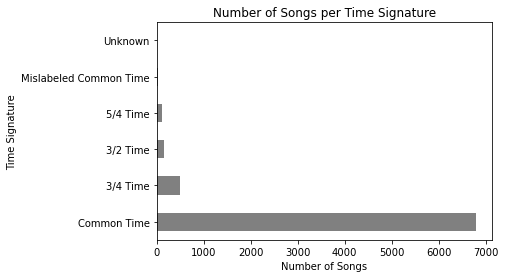

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.gca() # provides handle of last avaiable axes
df['timesignature'].value_counts(sort=True).plot(kind='barh',
                                              color='0.5',
                                              x="Number of Songs",
                                              y="Time Signature",
                                              ax=ax
                                              )
ax.set_yticklabels(['Common Time','3/4 Time','3/2 Time',
                    '5/4 Time','Mislabeled Common Time', 'Unknown'])
ax.set_title("Number of Songs per Time Signature")
ax.set_xlabel("Number of Songs")
ax.set_ylabel("Time Signature")
plt.show()

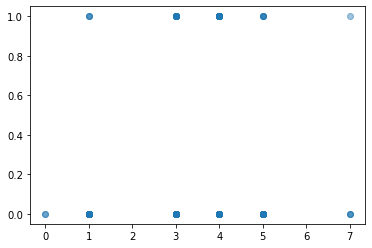

In [21]:
plt.scatter(df['timesignature'], df['Top10'],  alpha=0.1)
plt.show()

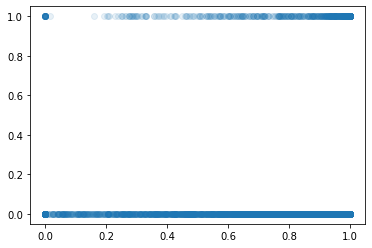

In [22]:
plt.scatter(df['timesignature_confidence'], df['Top10'],  alpha=0.1)
plt.show()

In [23]:
corr, _ = pearsonr(df['timesignature'], df['timesignature_confidence'])
print('Pearsons correlation: %.3f' % corr) # lowish correlation

Pearsons correlation: 0.333


The above graphs indicate that time signature by itself may not be the best predictor given that the vast majority of songs are in common time. For this reason, I will most likely treat time signature as a binary indicator of common time instead.

However, if we look at the confidence of the time signature estimate in the last scatterplot, we see that hit songs have a different pattern than non-hit songs, indicating that when a song is a hit, it is more likely to have higher confidence in the time signature. 

Note that confidence levels in this dataset are more like a measurements of variability since most songs change time signatures and are not constant from beginning to end, hence the estimate. Time signatures with 0 confidence are difficult to estimate while 1 confidence are consistent throughout.

### **Tempo**
- estimated beats per minute
- confidence in the estimate

In [24]:
# minimum and maximum of this variable
print(df['tempo'].min(),df['tempo'].max())

0.0 244.30700000000002


Text(0.5, 1.0, 'Histogram of Tempo')

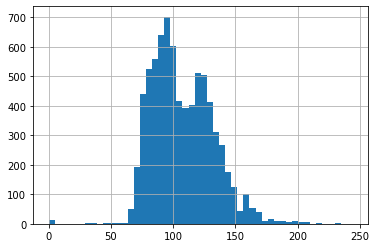

In [25]:
df['tempo'].hist(bins=50)
ax.set_title("Histogram of Tempo")

The above histogram actually indicates a relatively normal distribution when it comes to tempo.

However, a song should not have a tempo of 0 so these songs will be investigated.

In [26]:
df[df["tempo"] == 0].head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
619,2009,Blue Skies,Noah and the Whale,SOCFHXO1376DC31A9C,AR9ZC461187FB511F7,3,1.0,-12.513,0.0,0.0,4,0.451,0.850820,0.002,0.037,51.254,-260.084,170.413,-232.188,34.481,-188.250,322.603,-63.400,136.926,-203.953,122.801,-81.765,84.365,-154.403,188.146,-53.611,38.731,-82.969,101.368,-87.543,51.911,-44.956,35.817,0
1077,2008,Intro,Ludacris,SODTNYT12A8C1336BC,AR7NPRY1187B9ADE15,0,0.0,-22.751,0.0,0.0,5,0.229,0.443686,0.059,0.000,40.939,-31.040,353.588,-125.185,93.102,-318.146,124.147,-67.817,57.491,-65.790,93.617,-91.898,46.283,-90.150,99.482,-61.513,39.937,-71.852,90.421,-108.418,90.746,-21.449,51.039,0
1486,2007,Without You,J. Holiday,SOWAHGM13167716458,ARDV3AV1187FB551C9,0,0.0,-6.822,0.0,0.0,1,0.350,0.798697,0.002,2.290,55.955,-21.420,208.535,-155.270,149.368,-165.259,363.345,-54.602,123.872,-231.229,80.475,-63.924,86.050,-51.803,79.024,-55.755,56.452,-77.861,49.387,-64.135,42.226,-66.071,33.389,0
2146,2006,Intro,Lyfe Jennings,SOPTKOM12E72FD37E9,AR1HUQI1187B9AA854,1,0.0,-28.885,0.0,0.0,4,0.000,0.373423,0.541,0.013,12.582,123.730,180.901,8.953,49.392,-28.836,80.643,24.570,67.831,-50.161,126.060,-1.804,18.021,5.153,70.701,-34.794,-25.955,1.140,15.742,-66.248,-6.359,-20.137,19.347,0
2295,2006,Will We Ever Know How?,Valencia,SOLSPWQ1316771676A,ARJ85OC1187B9B4843,0,0.0,-4.538,0.0,0.0,4,0.483,0.931427,0.020,17.218,57.627,-39.447,119.808,-153.802,96.075,-353.812,376.754,-51.340,62.264,-98.514,87.584,-84.742,84.487,-85.567,69.521,-65.962,39.559,-50.714,65.064,-100.294,35.836,-50.460,26.340,0


While a majority of these songs were of a medium tempo, their tempo was vastly different from the very beginning of the song to the end. It's also worth noting that these are the same songs with a 0 for time signature. This indicates that our dataset assigns a 0 tempo to songs that are difficult to analyze (too short, mostly talking, bare instrumentals, indecipherable noise) and/or have inconsistent tempos. Therefore, it is safe to assume that the 0 tempo value correlates to an unknown tempo.

In [27]:
df.loc[(df['tempo'] > 0) & (df['tempo'] < 60),].head() # lower end

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
1136,2008,Bust It Baby Part 2,Plies,SOGLJZI1311AFE62D4,AR7Q0O91187FB4DBE7,1,0.00,-6.685,52.681,0.484,5,0.515,0.790813,0.007,25.390,55.845,-55.198,223.894,-174.037,125.248,-183.126,372.297,-68.629,167.319,-238.850,170.698,-92.828,64.749,-103.680,107.778,-73.944,66.646,-54.260,104.613,-95.806,95.332,-58.181,49.215,1
1197,2008,Stethoscope,Taproot,SOMMKEL1315CD4B048,ARB9VHL1187B9AEC3F,1,0.00,-17.246,50.943,0.538,7,0.147,0.404666,0.004,14.242,46.228,-180.511,76.844,-204.663,107.948,-79.492,116.089,-33.394,125.474,-65.149,93.495,-65.574,56.890,-46.690,113.759,-50.627,24.047,-34.933,63.202,-80.630,15.327,-27.846,35.384,0
1673,2007,Crayons Can Melt on Us for All I Care,Relient K,SONPWCC12AF72A241D,ARYDTFO1187B99B1E0,1,0.00,-10.484,30.043,0.947,5,0.000,0.051479,0.016,0.000,49.107,-157.672,171.130,-119.909,46.743,-103.669,398.816,-14.789,114.271,-50.067,116.877,-69.992,30.829,-69.170,147.533,-27.228,34.097,-51.293,73.176,-56.082,60.212,-20.717,26.925,0
2319,2006,With Arms Wide Open,Various artists,SOWHDWD13777976521,ARAGWS81187FB3F768,4,0.00,-13.877,45.394,0.411,7,0.013,0.609806,0.009,5.427,51.309,-131.227,105.672,-242.095,66.923,-224.598,403.032,-73.902,82.568,-224.718,291.879,-83.028,80.624,-57.709,134.519,-54.135,40.505,-74.648,104.450,-177.928,106.491,-35.453,43.211,0
2483,2005,Clear the Area,Imogen Heap,SOCQJMK13752CD6330,AR7W7171187B9A8842,3,0.93,-13.731,59.801,0.445,4,0.249,0.142241,0.002,0.000,53.864,-233.292,187.726,-163.751,171.768,-264.688,169.155,-31.871,149.657,-74.824,151.315,-110.521,65.500,-135.814,86.260,-73.974,62.670,-74.726,82.969,-93.636,61.044,-56.142,54.448,0


A sample of these "slow songs" were as expected: either slow overall or had long passages of slow tempos.

In [28]:
df[df['tempo'] > 210].head() # upper end

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
1185,2008,Relentless,Strapping Young Lad,SODQTAK1377A1A8EB1,AR4IE571187FB4ECE1,4,0.000,-5.635,232.134,0.273,1,0.255,0.985397,0.021,0.004,56.715,32.727,171.054,-58.185,52.008,-101.999,128.657,-62.474,57.575,-69.647,117.034,-40.123,57.142,-31.888,33.870,-28.485,31.267,-19.105,26.089,-71.759,35.007,-34.933,46.100,0
1200,2008,Take It,Taproot,SOIEMEH131634A6F0D,ARB9VHL1187B9AEC3F,3,1.000,-4.229,218.207,0.177,2,0.367,0.976245,0.020,15.227,56.667,-5.680,181.148,-86.388,154.166,-327.447,185.665,-68.249,58.018,-79.600,81.716,-68.978,72.663,-41.392,68.613,-52.242,49.196,-33.076,57.878,-119.559,33.956,-33.002,39.616,0
2895,2004,Holiday in Cambodia,Dead Kennedys,SOICGDJ1373763F9F1,AR050VJ1187B9B13A7,4,0.704,-6.543,217.681,0.175,9,0.584,0.966298,0.007,0.176,55.987,-161.877,219.241,-51.725,222.823,-84.726,112.399,-114.829,107.845,-57.379,21.147,-72.804,170.607,-70.855,59.121,-53.160,110.311,-29.904,46.501,-55.497,18.293,-67.896,37.791,0
3518,2003,Interlude,Neal Morse,SOALPCD12A8C142065,ARTV3SB1187B997689,5,0.813,-7.067,217.025,0.349,8,0.300,0.966710,0.013,33.151,54.225,-145.378,120.319,-63.683,102.704,-135.915,47.892,-50.520,57.632,-74.388,37.936,-52.461,42.079,-57.389,45.199,-73.544,38.470,-46.188,28.541,-44.246,26.363,-22.454,58.355,0
4090,2002,You're a Fucking Bastard,The Exploited,SOCKWLO12D85320AB2,AR39QZK1187B9B1846,1,0.000,-5.677,233.982,0.338,1,0.681,0.981685,0.015,5.293,54.336,-202.536,143.015,-168.773,86.208,-104.094,224.025,-118.557,34.375,-74.913,45.120,-26.064,91.916,-79.658,60.900,-49.601,46.883,-26.752,55.947,-108.579,40.632,-37.253,37.228,0


A sample of these "fast songs" were as expected: extremely fast.

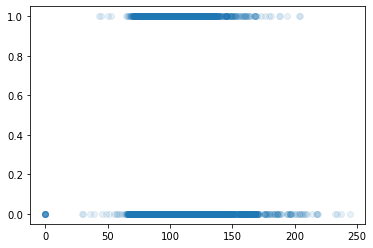

In [29]:
plt.scatter(df['tempo'], df['Top10'],  alpha=0.1)
plt.show() # hit songs have a smaller range

## **Key**
- variable with 12 labels
- estimates the key
- confidence in the estimate

In [30]:
df['key'].value_counts(sort=True)

7     907
9     847
2     830
0     803
1     725
11    652
4     624
6     544
5     512
10    482
8     434
3     214
Name: key, dtype: int64

The very first issue that pops up with this variable is undefined labels. There are 12 different keys but no dictionary to define them. Therefore, I will analyze songs with 100% confidence in their key signature to determine which keys coordinate with each label.

In [31]:
df[df["key_confidence"] == 1]

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
141,2010,Don't You Want To Share The Guilt?,Kate Nash,SOIAICZ1315CD4F99E,ARUZIPI1187FB5454A,4,0.990,-6.966,84.455,0.405,7,1.0,0.722098,0.015,0.000,55.925,-123.363,389.997,-117.289,166.581,-80.902,73.670,-52.550,166.866,-93.222,46.947,-53.516,63.954,-115.120,69.134,-110.040,85.811,-82.825,70.034,-67.110,29.576,-38.402,52.006,0
148,2010,Later On,Kate Nash,SORAMKD131634AA473,ARUZIPI1187FB5454A,4,0.928,-5.855,142.996,0.402,0,1.0,0.829650,0.034,4.724,56.585,-110.203,143.525,-101.047,102.746,-215.517,126.843,-44.579,142.076,-75.550,266.427,-56.031,62.192,-90.309,64.590,-88.586,41.525,-50.205,80.019,-66.911,38.834,-50.193,36.077,0
393,2009,Cold Fame,Band of Skulls,SOEERWR1315CD4A7BE,ARONQXK122BCFC9386,4,0.893,-7.408,115.316,0.534,2,1.0,0.388536,0.002,0.349,57.267,-204.115,211.595,-192.640,80.983,-251.711,319.624,-93.634,107.158,-220.739,159.329,-84.272,79.796,-88.884,96.982,-57.981,67.828,-82.695,53.050,-79.136,68.842,-52.010,49.962,0
487,2009,Make a Run for It / The Call Out,Hit the Lights,SOVDCZD13167716C6C,ARSASTM1187FB52759,4,1.000,-7.402,79.991,0.631,0,1.0,0.399995,0.011,0.000,55.693,-94.640,171.130,-125.261,98.051,-385.234,118.853,-48.167,143.640,-74.930,145.725,-78.493,75.436,-85.489,65.551,-71.399,26.848,-56.810,68.662,-72.268,48.047,-62.753,37.905,0
733,2009,You Belong With Me,Taylor Swift,SOWPETX13AA4F55DB8,ARS54I31187FB46721,4,0.668,-16.594,133.978,0.955,6,1.0,0.380103,0.003,21.532,47.825,-101.358,247.994,-186.698,122.490,-171.599,117.428,-67.741,121.661,-98.837,154.240,-97.229,84.442,-132.095,107.400,-34.193,61.199,-60.069,101.643,-100.135,61.224,-55.421,51.355,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6946,1992,One of Those Days,Ocean Colour Scene,SOQMHNM1315CD46F5B,ARQNR1G1187B9AE88F,4,0.883,-6.207,117.020,0.645,9,1.0,0.835735,0.010,0.000,55.996,-139.948,171.130,-61.500,134.815,-265.911,167.969,-49.047,91.932,-85.976,67.087,-75.665,27.821,-39.342,40.296,-44.756,56.641,-31.144,50.524,-82.267,40.320,-35.822,53.325,0
7048,1992,Everything About You,Ugly Kid Joe,SOBPXUN135CBD88519,AR9PTYM1187B9BA3D6,4,0.823,-8.805,122.737,0.686,1,1.0,0.766762,0.003,0.003,53.406,-106.391,214.036,-159.896,219.696,-158.620,406.090,-96.089,114.528,-102.709,115.317,-97.624,71.888,-80.022,99.504,-54.994,55.660,-69.416,43.705,-84.400,48.976,-70.222,53.186,1
7151,1991,Blissed,Jesus Jones,SOGCYAG131677142E2,AR2HXXS1187B9AF3E2,4,1.000,-16.097,101.736,1.000,9,1.0,0.521885,0.008,0.169,48.977,-217.609,245.207,-210.493,150.446,-130.459,170.082,-72.464,74.785,-114.805,93.723,-54.180,108.675,-67.068,81.648,-60.497,57.175,-50.545,51.670,-77.960,23.982,-47.837,45.217,0
7250,1990,Mistress for Christmas,AC/DC,SOTFGLQ12C0DD04AF7,ARWR05M1187B9951A2,4,0.998,-5.074,111.869,0.587,9,1.0,0.863028,0.014,0.003,57.707,-65.036,171.059,-120.148,120.145,-210.189,398.907,-63.060,85.855,-77.250,212.806,-73.045,61.266,-66.807,114.062,-57.128,38.823,-47.275,45.969,-98.854,56.479,-47.765,29.136,0


Using songs that were 100% confident in their key signatures, I was able to determine which key corresponds to each number. 

0. C
1. C#/Db
2. D
3. D#/Eb
4. E
5. F
6. F#/Gb
7. G
8. G#/Ab
9. A
10. A#/Bb
11. B


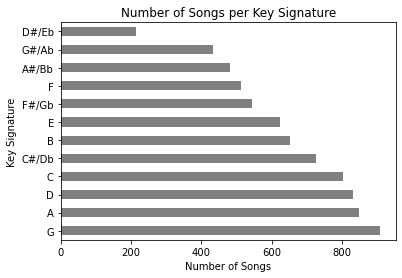

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.gca() # provides handle of last avaiable axes
df['key'].value_counts(sort=True).plot(kind='barh',
                                              color='0.5',
                                              x="Number of Songs",
                                              y="Key Signature",
                                              ax=ax
                                              )
ax.set_yticklabels(['G','A','D','C','C#/Db', 'B', 'E',
                    'F#/Gb', 'F', 'A#/Bb','G#/Ab','D#/Eb'])
ax.set_title("Number of Songs per Key Signature")
ax.set_xlabel("Number of Songs")
ax.set_ylabel("Key Signature")
plt.show()

<AxesSubplot:>

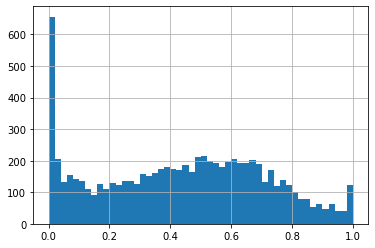

In [33]:
# Histogram of Key Confidence
df['key_confidence'].hist(bins=50)

The above histogram shows a majority of uncertain keys. This is not a good sign in terms of accuracy. We want the model to know what key signatures are being analyzed otherwise the model will not be useful.

One option might be to subset the data set to only include songs that are highly confident. For example, if I only look at observations with at least a 80% confidence level, I can maintain a similar proportion of hits to non-hits. However, while this method might improve the accuracy of values used, it will introcue a lot of bias into the model.

In [34]:
original = df['Top10'].value_counts()
subset = df.loc[(df['key_confidence'] >= 0.80) ,'Top10'].value_counts(sort=False)
prop_tempo = {"original" : original[1]/original[0], "subset" : subset[1]/subset[0]}
prop_tempo # larger proportion in the subset

{'original': 0.17335398915569325, 'subset': 0.18010291595197256}

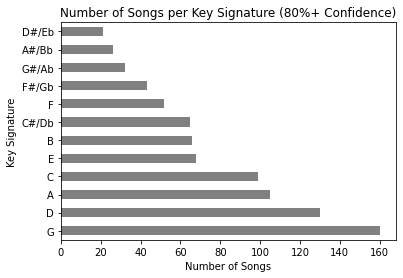

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.gca() # provides handle of last avaiable axes
df.loc[(df['key_confidence'] > 0.77) ,'key'].value_counts(sort=True).plot(kind='barh',
                                              color='0.5',
                                              x="Number of Songs",
                                              y="Key Signature",
                                              ax=ax
                                              )
ax.set_yticklabels(['G','D','A','C','E', 'B', 'C#/Db', 'F', # the order changed slightly
                    'F#/Gb','G#/Ab','A#/Bb','D#/Eb'])
ax.set_title("Number of Songs per Key Signature (80%+ Confidence)")
ax.set_xlabel("Number of Songs")
ax.set_ylabel("Key Signature")
plt.show()

Because of the bias issue, I will most likely keep observations with lower confidence levels. This confidence is an indication of the variability of a song's key signature. Since the majority of songs do end in different keys than they start in (for dramatic effect), this variable can help quantify that change.

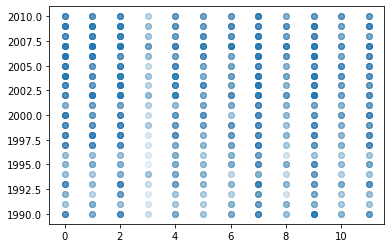

In [36]:
plt.scatter(df['key'], df['year'],  alpha=0.03)
plt.show() # consistent throughout the years

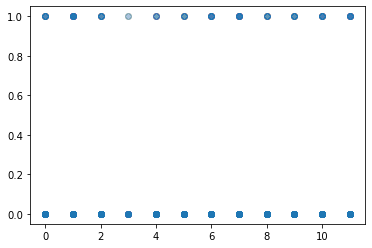

In [37]:
plt.scatter(df['key'], df['Top10'],  alpha=0.01)
plt.show() # bad indicator of hit song

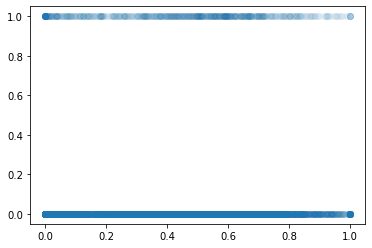

In [38]:
plt.scatter(df['key_confidence'], df['Top10'],  alpha=0.03)
plt.show()

In [39]:
corr, _ = pearsonr(df['key'], df['key_confidence'])
print('Pearsons correlation: %.3f' % corr) # small correlation

Pearsons correlation: -0.043


### **Loudness**
- a continuous variable indicating the average amplitude of audio in decibels

In [40]:
# minimum and maximum of this variable
print(df['loudness'].min(),df['loudness'].max())

-42.451 1.305


Text(0.5, 1.0, 'Histogram of Loudness')

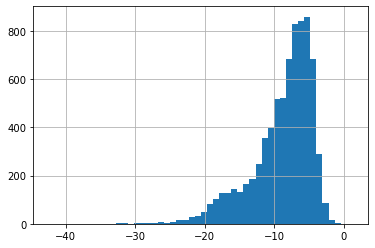

In [41]:
%matplotlib inline

df['loudness'].hist(bins=50)
ax.set_title("Histogram of Loudness")

The histogram shows that the majority of songs have a loudness level below 0 but the maximum loudness value is 1.305 so I will dive deeper into the songs at the right end of this graph. 

In [42]:
df[df["loudness"] > 0]

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
556,2009,Red Bird of Summer Part 1,Merzbow,SOBKSIF1373406BA88,AREBLP31187FB4F35F,3,0.734,0.141,95.709,0.045,11,0.349,0.998492,0.016,7.807,63.337,-173.733,260.168,-101.482,111.481,-158.933,255.557,-83.673,98.088,-76.102,23.190,-79.120,91.918,-57.815,89.442,-93.816,50.160,-45.211,38.191,-58.585,14.359,-57.033,57.804,0
558,2009,Red Bird of Summer Part 2,Merzbow,SOBSLMA1373401FAB3,AREBLP31187FB4F35F,4,0.176,1.305,107.972,0.012,11,0.570,0.998203,0.010,19.525,64.007,-7.347,388.841,-173.271,160.496,-108.740,206.048,-120.696,77.971,-109.919,29.275,-68.124,101.035,-53.857,89.767,-104.533,50.327,-43.551,57.300,-88.407,29.667,-62.634,64.537,0


Upon further research, this is part 2 of a 40 minute song from the "Japanoise/Power Electronics" genre, which is basically screaming, banging, and power drills. I personally do not believe that their loudness score was an error, simply a warning for headphone users.

I will now look into the other songs to confirm the loudness scale is essentially: the closer to 0, the louder the song.

In [43]:
# df[df["loudness"] > -2].head()
df[df["loudness"] < -30].head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
1926,2006,Heard from Telegraph Lines,Boards of Canada,SOUDJNH12AB01810E5,AROG07L1187FB4C826,3,0.944,-31.253,68.629,0.683,0,0.000,0.044701,0.140,0.011,33.840,-216.036,170.898,0.213,155.969,-51.691,70.932,18.182,127.021,-75.294,-17.038,4.503,107.747,-19.354,100.523,-40.826,10.475,-33.690,27.774,-27.930,11.643,-38.364,20.617,0
2306,2006,Wham!,Various artists,SOZFIIV134EE36AAC7,ARAGWS81187FB3F768,1,0.000,-42.451,166.597,0.198,1,0.102,0.139644,0.099,0.000,16.623,51.820,212.961,-17.329,110.532,-107.896,90.710,-16.469,80.808,-50.067,63.034,-65.620,30.958,-50.011,35.121,-65.252,32.226,-32.257,50.599,-46.960,21.676,-44.035,33.726,0
3679,2002,One in a Million,Aaliyah,SOJPTBB12C0DD0541B,ARDNYW01187FB4D0FB,4,0.980,-32.736,150.839,0.758,6,0.483,0.081599,0.008,0.308,30.284,-67.020,318.606,-156.563,150.577,-146.146,159.409,-95.745,253.466,-66.368,173.457,-100.331,75.415,-83.611,110.596,-76.927,69.177,-66.452,83.405,-51.171,55.068,-48.511,73.752,0
3775,2002,Intro,Buckethead,SOTSRRH12D9F523E02,ARGCS3B1187B9B3776,1,0.000,-30.398,150.593,0.410,8,0.242,0.005257,0.002,0.000,29.843,-55.946,171.130,9.469,262.272,-72.573,86.108,51.426,135.825,-50.067,-9.028,-13.917,36.626,-50.491,27.375,-32.948,69.939,-12.902,20.708,-10.640,26.063,-19.774,90.101,0
5802,1997,Leaving Behind...,Robert Miles,SODMGWE1313439E844,AR2VJL41187B98F372,3,0.530,-31.206,77.114,0.287,9,0.752,0.123960,0.003,3.890,37.472,-208.540,184.570,-154.202,211.833,-180.605,99.072,-97.919,134.151,-81.928,85.728,-76.245,91.742,-66.401,75.876,-81.136,34.229,-54.421,45.158,-35.928,50.409,-50.825,62.139,0


Upon sampling songs on both ends, I am able to confirm that the loudness variable ranks songs from quietest to loudness with large negative numbers indicating quiet songs and numbers near 0 representing loud songs.

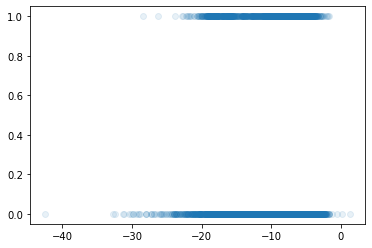

In [44]:
plt.scatter(df['loudness'], df['Top10'],  alpha=0.1)
plt.show() # hit songs have a smaller range in volume

### **Energy**
- overall acoustic energy of the song
- uses a mix of features such as loudness
    - Will need to check for multicollinearity with this variable in the model

Text(0.5, 1.0, 'Histogram of Energy')

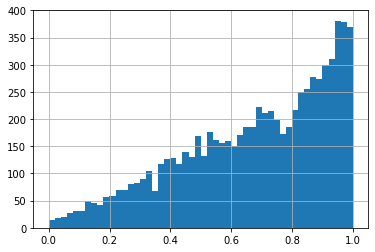

In [45]:
df['energy'].hist(bins=50)
ax.set_title("Histogram of Energy")

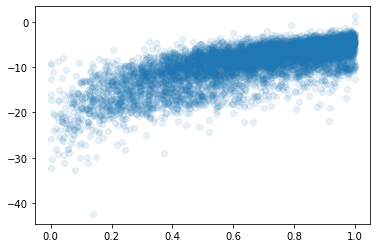

In [46]:
plt.scatter(df['energy'], df['loudness'],  alpha=0.1)
plt.show()

In [47]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df['energy'], df['loudness'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.742


In [48]:
df[df['energy'] > 0.99].head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
58,2010,Regret,Drowning Pool,SOMJHXP1315CD48E5D,ARVSQHB1187B992FF0,4,0.786,-3.247,163.989,0.474,1,0.610,0.997366,0.023,0.000,58.078,-39.652,195.606,-124.232,124.787,-94.503,391.635,-48.709,86.381,-77.095,91.983,-81.393,45.844,-91.989,100.725,-67.806,41.940,-66.275,48.954,-162.716,63.510,-36.704,53.403,0
254,2010,In Vain,Overkill,SOFHLQE12AB018CA96,ARIZ6AI1187FB5197C,4,0.455,-4.477,105.596,0.080,9,0.000,0.994632,0.036,0.228,58.288,20.529,233.484,-125.337,61.566,-175.752,406.922,-70.806,55.364,-97.543,248.125,-78.255,82.704,-36.675,93.482,-48.341,42.783,-80.703,91.607,-96.388,95.008,-49.092,41.848,0
556,2009,Red Bird of Summer Part 1,Merzbow,SOBKSIF1373406BA88,AREBLP31187FB4F35F,3,0.734,0.141,95.709,0.045,11,0.349,0.998492,0.016,7.807,63.337,-173.733,260.168,-101.482,111.481,-158.933,255.557,-83.673,98.088,-76.102,23.190,-79.120,91.918,-57.815,89.442,-93.816,50.160,-45.211,38.191,-58.585,14.359,-57.033,57.804,0
558,2009,Red Bird of Summer Part 2,Merzbow,SOBSLMA1373401FAB3,AREBLP31187FB4F35F,4,0.176,1.305,107.972,0.012,11,0.570,0.998203,0.010,19.525,64.007,-7.347,388.841,-173.271,160.496,-108.740,206.048,-120.696,77.971,-109.919,29.275,-68.124,101.035,-53.857,89.767,-104.533,50.327,-43.551,57.300,-88.407,29.667,-62.634,64.537,0
641,2009,Show Me What You've Got,Powerman 5000,SOBIKCA13129A9164A,ARHJHO71187FB37F4A,4,1.000,-2.672,143.045,0.344,1,0.007,0.991203,0.035,0.854,58.726,13.802,195.844,-45.426,119.502,-82.753,62.350,-68.026,57.598,-76.594,16.425,-35.627,56.390,-84.926,60.104,-46.238,37.133,-28.596,49.654,-44.611,35.156,-43.732,38.774,0


As expected, the songs with high energy are also songs that are considered loud. While a lot of other variables go into energy, such as danceability, timbre, and lyrics, I believe that energy and loudness will be highly correlated variables.

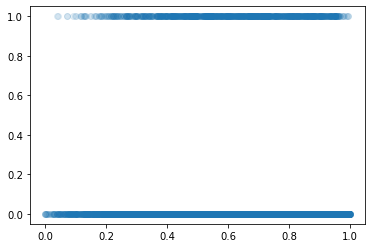

In [49]:
plt.scatter(df['energy'], df['Top10'],  alpha=0.1)
plt.show() # hit songs have a smaller range in energy

### **Pitch**
- continuous variable that indicates the pitch of the song

Before analyzing this variable, it is important to know the difference between pitch and key signature. Pitch is a measurement of frequency while key is a musical concept that uses a collection of pitches.

Above we analyzed key signature, which can be thought of as central pitch of a song, where all the harmony, melody, tension, etc. is based off of. Now, we will look at the quantification of this variable.

Text(0.5, 1.0, 'Histogram of Pitch')

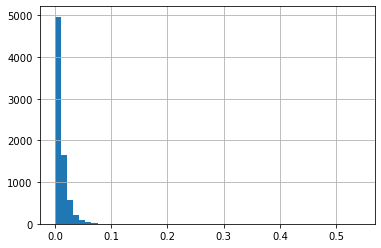

In [50]:
df['pitch'].hist(bins=50)
ax.set_title("Histogram of Pitch")

In [51]:
print(df['pitch'].min(),df['pitch'].max())

0.0 0.541


In [52]:
# only view the right tail
df[df["pitch"] > 0.1].sort_values(by = "pitch", ascending = False).head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
2146,2006,Intro,Lyfe Jennings,SOPTKOM12E72FD37E9,AR1HUQI1187B9AA854,1,0.000,-28.885,0.000,0.000,4,0.000,0.373423,0.541,0.013,12.582,123.730,180.901,8.953,49.392,-28.836,80.643,24.570,67.831,-50.161,126.060,-1.804,18.021,5.153,70.701,-34.794,-25.955,1.140,15.742,-66.248,-6.359,-20.137,19.347,0
5587,1997,Windchimes,Anal Cunt,SONGRNV12A58A7D466,ARL14X91187FB4CF14,1,0.538,-9.502,63.075,0.557,10,0.000,0.897016,0.235,2.772,49.418,20.442,161.369,-90.299,75.483,-96.540,319.141,-91.955,48.864,-65.468,127.655,-48.960,52.503,-68.378,99.444,-38.455,27.973,-33.651,31.992,-111.792,43.318,-8.811,39.955,0
3350,2003,Inside Fort Meade,Cult of Luna,SOTHGNI12AF72A943A,ARLE5971187FB38C21,4,0.831,-24.026,116.779,0.391,4,0.000,0.186890,0.174,0.000,38.938,-109.366,171.130,-26.861,82.565,-93.023,83.272,-53.953,57.491,-53.868,23.263,-34.879,53.871,-44.526,15.699,-27.228,16.187,-14.457,46.148,-102.946,25.767,-17.677,7.200,0
5088,1999,Commercial One,Silkk the Shocker,SOEHOML12AF72A9BF6,AR2TSU61187FB5C4F0,3,1.000,-15.426,91.500,0.000,11,0.272,0.689150,0.153,6.743,50.451,-90.064,213.909,-117.091,105.323,-111.905,105.054,-28.942,103.885,-92.071,109.732,-52.993,53.456,-81.113,104.048,-56.267,53.340,-82.696,64.473,-74.752,42.449,-22.277,32.889,0
1926,2006,Heard from Telegraph Lines,Boards of Canada,SOUDJNH12AB01810E5,AROG07L1187FB4C826,3,0.944,-31.253,68.629,0.683,0,0.000,0.044701,0.140,0.011,33.840,-216.036,170.898,0.213,155.969,-51.691,70.932,18.182,127.021,-75.294,-17.038,4.503,107.747,-19.354,100.523,-40.826,10.475,-33.690,27.774,-27.930,11.643,-38.364,20.617,0


In [53]:
# upper end of the majority of songs
df[df["pitch"] < 0.06].sort_values(by = "pitch", ascending = False).head()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
1077,2008,Intro,Ludacris,SODTNYT12A8C1336BC,AR7NPRY1187B9ADE15,0,0.000,-22.751,0.000,0.000,5,0.229,0.443686,0.059,0.000,40.939,-31.040,353.588,-125.185,93.102,-318.146,124.147,-67.817,57.491,-65.790,93.617,-91.898,46.283,-90.150,99.482,-61.513,39.937,-71.852,90.421,-108.418,90.746,-21.449,51.039,0
835,2009,The Hold,Woods,SODMKRQ12AF729E40B,AR4SDA71187B9A7C97,4,1.000,-11.029,117.674,0.940,7,0.028,0.513351,0.059,0.000,53.216,-153.265,171.130,-108.483,120.137,-118.842,168.792,-27.611,99.983,-69.433,118.771,-83.804,30.620,-48.850,51.686,-47.350,50.152,-60.129,38.463,-70.442,30.862,-28.585,49.106,0
5875,1997,Standards,The Jam,SOMYXYV12A67020D53,ARJG2ID1187B9A767E,4,1.000,-12.447,162.191,0.109,1,0.002,0.945323,0.059,0.104,49.527,14.700,218.046,-75.351,175.626,-63.170,246.083,-49.413,94.514,-81.848,64.254,-65.814,52.507,-48.587,59.989,-48.365,45.516,-41.045,42.811,-86.739,27.974,-34.324,46.839,0
1388,2007,Very Young,Charlotte Hatherley,SODYXQR13770E040D8,AR1HSHQ1187B9A2140,4,0.747,-4.605,160.387,0.440,2,0.355,0.991161,0.058,1.169,58.525,-36.237,205.800,-42.818,111.487,-154.054,285.436,-34.920,55.854,-71.294,225.833,-52.503,63.106,-54.645,51.783,-53.604,46.275,-50.492,44.991,-50.146,51.907,-35.172,35.334,0
6742,1993,Give and Get,Pennywise,SOBIRQT12AF72A41EB,ARGFFA01187B9A2D11,4,1.000,-4.944,87.351,0.959,7,0.881,0.991498,0.058,0.576,57.238,19.885,207.705,-73.330,162.399,-280.378,447.785,-54.786,93.779,-94.326,159.882,-80.663,72.320,-68.496,83.179,-56.803,55.757,-51.594,54.359,-68.007,46.290,-29.516,54.591,0


In [54]:
# lower end of the majority of songs
df[df["pitch"] < 0.06].sort_values(by = "pitch", ascending = False).tail()

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
1485,2007,A Bay Bay,Hurricane Chris,SONWKAB1312A8ABFDD,AR6HBCV1187B98D3F9,4,0.658,-5.334,77.018,0.439,5,0.361,0.670481,0.0,0.162,58.096,-161.039,234.313,-209.333,155.715,-337.077,362.376,-72.375,190.432,-223.123,250.088,-126.153,95.589,-94.722,115.352,-80.908,78.670,-72.198,114.392,-121.739,69.783,-82.624,41.534,1
246,2010,We Here Now,Outlawz,SONXNVK137364E1E3D,AR76LOX1187B98FA01,5,0.878,-8.591,89.321,0.131,3,0.376,0.810836,0.0,8.902,54.720,-100.790,254.917,-147.439,172.625,-119.637,312.573,-77.276,103.169,-212.059,93.809,-75.632,93.102,-96.386,110.576,-66.038,61.764,-95.893,90.892,-69.175,38.482,-55.887,61.093,0
3682,2002,Don't Know What to Tell Ya,Aaliyah,SORYQLG13167718385,ARDNYW01187FB4D0FB,4,0.858,-6.956,79.888,0.167,2,0.419,0.549704,0.0,0.000,55.263,-215.438,171.130,-228.815,135.316,-173.673,187.054,-46.924,138.093,-104.295,138.316,-80.907,78.386,-127.198,84.958,-56.002,74.394,-58.280,87.525,-94.410,58.429,-66.924,69.379,0
1367,2007,Shortie Like Mine,Bow Wow,SOMTTNW13C5A4ECACC,ARRQZEV1187B98C8C2,4,0.919,-9.940,71.013,0.289,8,0.183,0.596923,0.0,0.000,52.686,-149.118,259.139,-190.283,141.556,-200.036,150.435,-88.667,140.641,-121.626,131.371,-91.263,87.854,-118.492,118.808,-67.807,63.421,-109.893,103.799,-128.299,48.246,-65.727,65.448,1
2238,2006,Eat Your Heart Up,The Blow,SODEDIY131343988B2,ARRGEL21187B98B3F8,4,0.995,-7.661,84.991,0.396,4,0.000,0.702519,0.0,2.247,54.692,-132.360,220.254,-157.319,113.997,-138.845,269.322,-44.535,97.111,-128.359,123.030,-83.222,74.539,-71.499,145.580,-45.352,35.346,-82.053,63.293,-84.144,39.148,-35.505,33.209,0


The majority of pitches acted as expected. The closer to 0, the lower the pitch, and the farther from 0, the higher the pitch. 

However, I noticed that a lot of the songs in the right tail were intros of albums or other instances where an artist was mostly talking, rather than performing a song. This was an interesting result but it is also worth mentioned that these songs typically had uncertain key signatures as well. 

Text(0.5, 1.0, 'Histogram of Pitch (80%+ Key Confidence)')

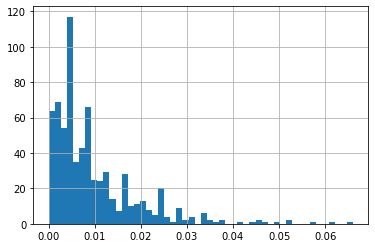

In [55]:
%matplotlib inline 
# only view pitch of songs with 80% Confidence in Key
df.loc[(df['key_confidence'] > 0.8) ,'pitch'].hist(bins=50)
ax.set_title("Histogram of Pitch (80%+ Key Confidence)")

This subset of songs with higher confidence in the key signature reveals a slightly less skewed pitch variable. But not by much.

In [56]:
corr, _ = pearsonr(df['key'], df['pitch'])
print('Pearsons correlation: %.3f' % corr) # small correlation

Pearsons correlation: 0.010


In [57]:
corr, _ = pearsonr(df['key_confidence'], df['pitch'])
print('Pearsons correlation: %.3f' % corr) # small correlation

Pearsons correlation: -0.082


### **Timbre**
- timbre is the perceived sound quality of a musical note, sound or tone
- variables that indicate the minimum/maximum values over all segments for each of the twelve values in the timbre vector
- results in 24 continuous variables



#### Timbre of Hit Songs

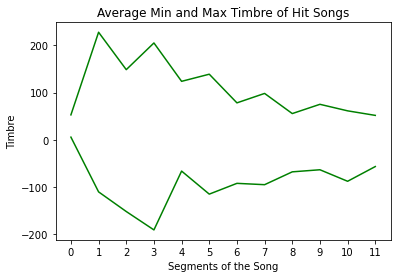

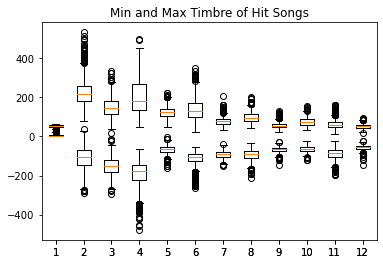

In [68]:
# minimum timbre of hit songs
row_index = np.where(df["Top10"] ==1)[0].tolist()
col_index = list(range(14,38,2)) # subset only the timbre variables

hit_min_timbre = df.iloc[row_index, col_index]
hit_min_timbre.columns = ['0','1','2','3','4','5','6','7','8','9','10','11']

# maximum timbre of hit songs
row_index = np.where(df['Top10'] ==1)[0].tolist()
col_index = list(range(15,39,2)) # subset only the timbre variables

hit_max_timbre = df.iloc[row_index, col_index]
hit_max_timbre.columns = ['0','1','2','3','4','5','6','7','8','9','10','11']

# average min and max timbre of hit songs
hit_timbre = {'min': hit_min_timbre.mean(), 'max': hit_max_timbre.mean()}
hit_timbre = pd.DataFrame(hit_timbre)

# Overall Average Timbre of Hit Songs
%matplotlib inline
plt.plot(hit_timbre['min'], 'g') 
plt.plot(hit_timbre['max'], 'g') 
plt.title('Average Min and Max Timbre of Hit Songs')
plt.xlabel('Segments of the Song')
plt.ylabel('Timbre')
plt.show()

# boxplot to demonstrate variance in timbre

plt.boxplot(hit_min_timbre) 
plt.boxplot(hit_max_timbre) 
plt.title('Min and Max Timbre of Hit Songs')
plt.show() 

#### Timbre of Unpopular Songs

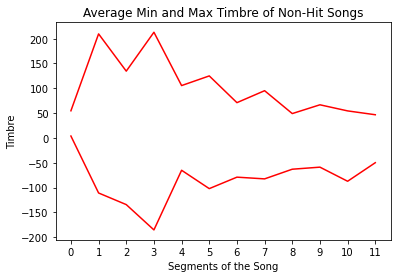

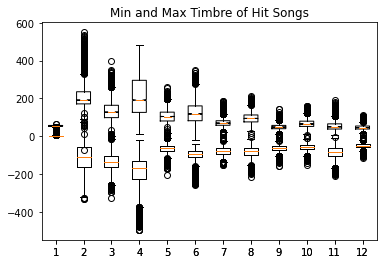

In [73]:
# minimum timbre of non-hit songs
row_index = np.where(df['Top10'] == 0)[0].tolist()
col_index = list(range(14,38,2)) # subset only the timbre variables

non_hit_min_timbre = df.iloc[row_index, col_index]
non_hit_min_timbre.columns = ['0','1','2','3','4','5','6','7','8','9','10','11']

# maximum timbre of non-hit songs
row_index = np.where(df['Top10'] ==0)[0].tolist()
col_index = list(range(15,39,2)) # subset only the timbre variables

non_hit_max_timbre = df.iloc[row_index, col_index]
non_hit_max_timbre.columns = ['0','1','2','3','4','5','6','7','8','9','10','11']

# average min and max timbre of hit songs
non_hit_timbre = {'min': non_hit_min_timbre.mean(), 'max': non_hit_max_timbre.mean()}
non_hit_timbre = pd.DataFrame(non_hit_timbre)

# Overall Average Timbre of Non-Hit Songs
%matplotlib inline
plt.plot(non_hit_timbre['min'], 'r')
plt.plot(non_hit_timbre['max'], 'r')
plt.title('Average Min and Max Timbre of Non-Hit Songs')
plt.xlabel('Segments of the Song')
plt.ylabel('Timbre')
plt.show()

# boxplot to demonstrate variance in timbre
plt.boxplot(non_hit_min_timbre) 
plt.boxplot(non_hit_max_timbre, 'm') 
plt.title('Min and Max Timbre of Hit Songs')
plt.show() 

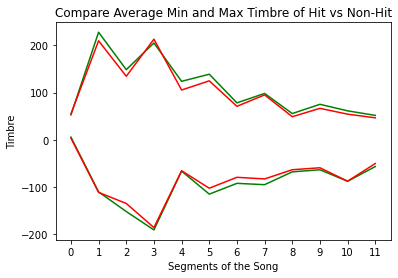

In [69]:
# Comparison
%matplotlib inline
plt.plot(hit_timbre['min'], 'g')
plt.plot(hit_timbre['max'], 'g')
plt.plot(non_hit_timbre['min'], 'r')
plt.plot(non_hit_timbre['max'], 'r')
plt.title('Compare Average Min and Max Timbre of Hit vs Non-Hit')
plt.xlabel('Segments of the Song')
plt.ylabel('Timbre')
plt.show()

The red lines are non-hit songs while green lines are hit songs. A close look at the above graph shows that the average timbres are further apart. These means that hit songs tend to be more drastic over the course of a song than non-hit songs.